# Importation des packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,  max_error,root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from joblib import dump



# Importation des données

In [2]:
# Vérifier le répertoire courant
current_directory = os.getcwd()


# Chemin relatif vers le fichier 
file_X_train = os.path.join(current_directory,'..', 'Data/Processed', 'X_train.csv')
file_X_test = os.path.join(current_directory,'..','Data/Processed' , 'X_test.csv')
file_y_train = os.path.join(current_directory,'..', 'Data/Processed', 'y_train.csv')
file_y_test = os.path.join(current_directory,'..', 'Data/Processed', 'y_test.csv')

# Charger les fichiers CSV
X_train = pd.read_csv(file_X_train, sep=';')
X_test = pd.read_csv(file_X_test, sep=';')
y_train= pd.read_csv(file_y_train, sep=';')
y_test= pd.read_csv(file_y_test, sep=';')



# Charger les fichiers CSV qui ne vont pas subir de modifications
X_train_s = pd.read_csv(file_X_train, sep=';')
X_test_s = pd.read_csv(file_X_test, sep=';')
y_train_s = pd.read_csv(file_y_train, sep=';')
y_test_s = pd.read_csv(file_y_test, sep=';')

# Afficher les premières lignes des fichier
print(X_train.head())

   OverallQual  HeatingQC  MSSubClass  BsmtQual  GarageFinish  Neighborhood  \
0            5        2.0          20       3.0           2.0      0.154966   
1            6        3.0          60       4.0           2.0      0.055651   
2            5        3.0          30       2.0           0.0      0.074486   
3            5        4.0          50       4.0           1.0      0.017979   
4            5        2.0          50       3.0           1.0      0.017979   

   Exterior1st  GarageCars  FullBath  Dure_house  TotRmsAbvGrd  Dure_garage  
0     0.148116        0.25  0.333333    0.885246      0.250000     0.495327  
1     0.359589        0.50  0.666667    0.262295      0.416667     0.149533  
2     0.148116        0.00  0.333333    0.967213      0.166667     1.000000  
3     0.146404        0.25  0.333333    0.950820      0.416667     0.635514  
4     0.034247        0.25  0.666667    1.000000      0.333333     0.803738  


# Les modèles potentiels

Le choix fait ici est de  tester plusieurs modèles de régression, dont la régression linéaire, ridge, lasso, elasticNet, ainsi que des modèles d'arbres de décision comme RandomForest, XGBoost et AdaBoost, afin de sélectionner le modèle le plus performant pour la prédiction des prix de maisons. Ces choix sont guidés par les raisons ci-après:  

1. Régression linéaire : Ce modèle simple nous sert de référence initiale pour la prédiction des prix de maison. Bien qu'il ne puisse pas capturer les relations non linéaires, il offre une base pour évaluer la performance des modèles plus complexes.  

2. Ridge et Lasso : Ces deux variantes de la régression linéaire régularisée sont adaptées pour gérer des modèles avec un grand nombre de variables, comme c'est le cas ici, et prévenir le sur-apprentissage, ce qui est crucial avec notre nombre relativement limité de données (1460 observations au total).

3. ElasticNet : Ce modèle combine les avantages de la régularisation Lasso et Ridge, ce qui permet de traiter des jeux de données avec des relations complexes tout en sélectionnant les variables les plus pertinentes pour la prédiction.

4. RandomForest : Ce modèle basé sur des arbres de décision, nous permet de capturer des relations non linéaires et des interactions complexes entre les variables, ce qui est particulièrement pertinent dans notre cas. Il est couramment utilisé dans la littérature et les compétitions comme Kaggle pour des problèmes similaires.

5. XGBoost : XGBoost est une méthode de gradient boosting très performante, souvent utilisée dans des compétitions comme Kaggle, en raison de sa capacité à gérer des relations non linéaires et de sa robustesse face aux données bruyantes. Il est bien adapté pour des prédictions complexes comme celles des prix de maison.

6. AdaBoost : Ce modèle, qui combine plusieurs classificateurs faibles pour améliorer la précision, est efficace pour modéliser des données complexes. Bien qu'il soit moins populaire que XGBoost ou RandomForest, il peut offrir de bonnes performances pour prédire les prix de maison en exploitant les interactions subtiles entre les variables.

 Ces modèles variés nous permettrons donc  de comparer des approches simples, régularisées et complexes, et d'identifier celui qui optimise le mieux la performance sur notre jeu de données.

## Fonction de génération des modèles

In [3]:
def train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type, params=None):
   
    # Sélectionner et instancier le modèle
    if model_type == "linear":
        model = LinearRegression()
    elif model_type == "ridge":
        alpha = params.get("alpha", 1.0) if params else 1.0
        model = Ridge(alpha=alpha)
    elif model_type == "lasso":
        alpha = params.get("alpha", 1.0) if params else 1.0
        model = Lasso(alpha=alpha)
    elif model_type == "elasticnet":
        alpha = params.get("alpha", 1.0) if params else 1.0
        l1_ratio = params.get("l1_ratio", 0.5) if params else 0.5
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elif model_type == "RandomForest":
        n_estimators = params.get("n_estimators", 100) if params else 100
        random_state = params.get("random_state", 42) if params else 42
        model= RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    elif model_type == "XGBoost":
        n_estimators = params.get("n_estimators", 100) if params else 100
        random_state = params.get("random_state", 42) if params else 42
        learning_rate=params.get("learning_rate", 0.1) if params else 0.1
        objective= params.get("objective", "reg:squarederror") if params else "reg:squarederror"
        model= XGBRegressor(n_estimators=n_estimators, random_state=random_state, learning_rate=learning_rate, objective=objective)
    elif model_type == "AdaBoost":
        n_estimators = params.get("n_estimators", 100) if params else 100
        random_state = params.get("random_state", 42) if params else 42
        model= AdaBoostRegressor(n_estimators=n_estimators, random_state=random_state)
    else:
        raise ValueError("Modèle non supporté. Choisissez parmi 'linear', 'ridge', 'lasso', 'elasticnet'.")

    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédictions sur le jeu de test
    y_pred = model.predict(X_test)

    # Calculer les métriques de performance
    mse = mean_squared_error(y_test, y_pred) #mean squared error
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
    rmse =root_mean_squared_error(y_test, y_pred) # Root Mean Squared Error
    maxerror = max_error(y_test, y_pred)       # Maximum Error


    return {"mse": mse, "r2": r2, "mae": mae, "rmse": rmse, "maxerror": maxerror}


## Entrainement et test des modèles

In [4]:
# Régression linéaire
metrics_linear = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="linear")


# Régression Ridge
metrics_ridge = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="ridge", params={"alpha": 10})

# Régression Lasso
metrics_lasso = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="lasso", params={"alpha": 0.5})

# Régression Elastic Net
metrics_elasticnet = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="elasticnet", params={"alpha": 0.5, "l1_ratio": 0.8})

# Régression RandomForest
metrics_RandomForest = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="RandomForest", params={"n_estimators":100, "random_state":42})

# Régression XGBoost
metrics_XGBoost = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="XGBoost", params={"n_estimators":100, "learning_rate":0.1, "random_state":42, "objective":"reg:squarederror"})

# Régression AdaBoost
metrics_AdaBoost = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="AdaBoost", params={"n_estimators":100, "random_state":42})




metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Elastic Net','RandomForest','XGBoost','AdaBoost'],
    'R2 Score': [metrics_linear['r2'], metrics_ridge['r2'], metrics_lasso['r2'], metrics_elasticnet['r2'],metrics_RandomForest['r2'],metrics_XGBoost['r2'], metrics_AdaBoost['r2']],
    'MSE': [metrics_linear['mse'], metrics_ridge['mse'], metrics_lasso['mse'], metrics_elasticnet['mse'],metrics_RandomForest['mse'],metrics_XGBoost['mse'], metrics_AdaBoost['mse']],
    'RMSE':  [metrics_linear['rmse'], metrics_ridge['rmse'], metrics_lasso['rmse'], metrics_elasticnet['rmse'],metrics_RandomForest['rmse'],metrics_XGBoost['rmse'], metrics_AdaBoost['rmse']],
    'MAE': [metrics_linear['mae'], metrics_ridge['mae'], metrics_lasso['mae'], metrics_elasticnet['mae'],metrics_RandomForest['mae'],metrics_XGBoost['mae'], metrics_AdaBoost['mae']],
    'MAXERROR': [metrics_linear['maxerror'], metrics_ridge['maxerror'], metrics_lasso['maxerror'], metrics_elasticnet['maxerror'],metrics_RandomForest['maxerror'],metrics_XGBoost['maxerror'], metrics_AdaBoost['maxerror']]
    
})

# Afficher les résultats
print(metrics_df.sort_values(by= 'R2 Score', ascending=False))

# Identifier le meilleur modèle en fonction de la métrique R2 (ou autre métrique de votre choix)
best_model = metrics_df.loc[metrics_df['R2 Score'].idxmax()]
best_model_MSE = metrics_df.loc[metrics_df['MSE'].idxmin()]


print(f"\nLe meilleur modèle est : {best_model['Model']} avec un R2 Score de {best_model['R2 Score']}")
print(f"\nLe  meilleur modèle est : {best_model_MSE['Model']} avec un MSE de {best_model_MSE['MSE']}")

c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


               Model  R2 Score           MSE          RMSE           MAE  \
5            XGBoost  0.857581  1.092400e+09  33051.472541  21890.585228   
4       RandomForest  0.846501  1.177385e+09  34313.043642  23385.916921   
6           AdaBoost  0.789016  1.618316e+09  40228.299726  30619.023008   
0  Linear Regression  0.751802  1.903757e+09  43632.068825  27805.823126   
2              Lasso  0.751797  1.903798e+09  43632.531681  27804.006189   
1              Ridge  0.740464  1.990728e+09  44617.572513  27689.675060   
3        Elastic Net  0.693441  2.351408e+09  48491.320794  30216.153334   

        MAXERROR  
5  183448.718750  
4  208220.030000  
6  175888.068548  
0  378737.847888  
2  378754.046240  
1  386534.706633  
3  407515.355883  

Le meilleur modèle est : XGBoost avec un R2 Score de 0.8575810457567583

Le  meilleur modèle est : XGBoost avec un MSE de 1092399837.1321204


On constate que le modèle XGBOOST performe déja  bien avec nos données et ceci peu importe la métrique utilisée. Essayons de voir si nous obtenons mieux après optimisation des hyperparamètres.

## Optimisation des hyperparamètres et validation croisée

Cette partie est consacrée à une évaluation optimale de la performance du modèle de régression linéaire et à l'optimisation des hyperparamètres pour pour les autres modèles(Ridge, Lasso, ElasticNet). Ceci va nous permettre d'évaluer un potentiel surajustement de  chaque modèle.

In [5]:
def cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="linear", params=None, cv=5):
    """
    Effectue une validation croisée et une optimisation des hyperparamètres pour différents modèles.
    
    - X_train : Les features d'entraînement
    - y_train : La cible d'entraînement
    - X_test : Les features de test
    - y_test : La cible de test
    - model_type : Le type de modèle ("linear", "ridge", "lasso", "elasticnet")
    - params : Dictionnaire des hyperparamètres à tester pour l'optimisation
    - cv : Nombre de folds pour la validation croisée
    """
    # Cas pour régression linéaire : pas d'optimisation d'hyperparamètres
    if model_type == "linear":
        model = LinearRegression()

        # Validation croisée sur les données d'entraînement
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        mean_mse = -cv_scores.mean()  # Les scores sont négatifs, donc on les inverse
        model.fit(X_train, y_train)  # Entraînement du modèle sur les données d'entraînement
        y_pred = model.predict(X_test)  # Prédictions sur les données de test
        test_mse = mean_squared_error(y_test, y_pred)  # MSE sur les données de test
        test_rmse = mean_squared_error(y_test, y_pred, squared=False) 
        test_mae = mean_absolute_error(y_test, y_pred)   
        test_maxerror = max_error(y_test, y_pred)      
         

        test_r2 = r2_score(y_test, y_pred)
        
        return {
            "model":model,
            "best_model": model,  # Même modèle ici car il n'y a pas d'optimisation
            "best_params": "N/A",  # Pas de paramètres à optimiser pour la régression linéaire
            "best_mse_train": mean_mse,
            "test_mse": test_mse,
            "test_r2": test_r2,
            "test_rmse": test_rmse,
            "test_mae": test_mae,
            "test_maxerror": test_maxerror
        }

    # Cas pour Ridge, Lasso, et ElasticNet : optimisation des hyperparamètres avec GridSearchCV
    elif model_type in ["ridge", "lasso", "elasticnet", "RandomForest","XGBoost","AdaBoost"]:
        if model_type == "ridge":
            model = Ridge()
            param_grid = {"alpha": np.logspace(-5, 5, 11)}  # Grille pour alpha
        elif model_type == "lasso":
            model = Lasso()
            param_grid = {"alpha": np.logspace(-5, 5, 11)}  # Grille pour alpha
        elif model_type == "elasticnet":
            model = ElasticNet()
            param_grid = {"alpha": np.logspace(-5, 5, 11), "l1_ratio": np.linspace(0, 1, 11)}  # Grille pour alpha et l1_ratio
        elif model_type == "RandomForest":
            model = RandomForestRegressor()
            param_grid = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]}
        elif model_type == "XGBoost":
            model = XGBRegressor() 
            param_grid =  {"n_estimators": [50, 100, 200],"learning_rate": np.logspace(-5, 5, 11),"max_depth": [3, 5, 7]}
        elif model_type == "AdaBoost":
            model = AdaBoostRegressor() 
            param_grid =  {"n_estimators": [50, 100, 200],"learning_rate": [0.01, 0.1, 1]}

        # Si des paramètres sont fournis, on les inclut dans la recherche
        if params:
            param_grid.update(params)

        # GridSearchCV pour optimiser les hyperparamètres
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Récupérer les résultats du meilleur modèle
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_mse_train = -grid_search.best_score_  # Inverser le signe du MSE

        # Entraînement du meilleur modèle sur les données d'entraînement
        best_model.fit(X_train, y_train)

        # Prédictions sur les données de test
        y_pred = best_model.predict(X_test)

        # MSE sur les données de test et de train
        test_mse = mean_squared_error(y_test, y_pred) 
        test_r2=r2_score(y_test,y_pred)
        test_rmse = mean_squared_error(y_test, y_pred, squared=False) 
        test_mae = mean_absolute_error(y_test, y_pred)   
        test_maxerror = max_error(y_test, y_pred)      
         

        return {
            "model": model_type,
            "best_model": best_model,
            "best_params": best_params,
            "best_mse_train": best_mse_train,
            "test_r2": test_r2,
            "test_mse": test_mse,
            "test_rmse": test_rmse,
            "test_mae": test_mae,
            "test_maxerror": test_maxerror
            
        }
    
    else:
        raise ValueError(f"Model type {model_type} not recognized. Choose from 'linear', 'ridge', 'lasso', or 'elasticnet'.")


## Entrainement et test des modèles après optimisation

In [6]:
# Liste pour stocker les résultats
results = []

# Conversion avec squeeze()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Appels des fonctions pour chaque modèle
result_linear = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="linear")
results.append([
    result_linear["model"],
    result_linear["best_model"],
    result_linear["best_params"],  # Pas de paramètres pour la régression linéaire
    result_linear["best_mse_train"],         # Moyenne du MSE en train pour la régression linéaire
    result_linear["test_mse"],
    result_linear["test_r2"],
    result_linear["test_rmse"],
    result_linear["test_mae"],
    result_linear["test_maxerror"]
])

result_ridge = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="ridge", params={"alpha": [10]})
results.append([
    result_ridge["model"],
    result_ridge["best_model"],
    result_ridge["best_params"],
    result_ridge["best_mse_train"],
    result_ridge["test_mse"], 
    result_ridge["test_r2"],
    result_ridge["test_rmse"],
    result_ridge[ "test_mae"],
    result_ridge["test_maxerror"]
])

result_lasso = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="lasso", params={"alpha": [0.5,1,2]})
results.append([
    result_lasso["model"],
    result_lasso["best_model"],
    result_lasso["best_params"],
    result_lasso["best_mse_train"],
    result_lasso["test_mse"],
    result_lasso["test_r2"],
    result_lasso["test_rmse"],
    result_lasso[ "test_mae"],
    result_lasso["test_maxerror"]
])

result_elasticnet = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="elasticnet", params={"alpha": [0.5, 1,2], "l1_ratio": [0.8]})
results.append([
    result_elasticnet["model"],
    result_elasticnet["best_model"],
    result_elasticnet["best_params"],
    result_elasticnet["best_mse_train"],
    result_elasticnet["test_mse"],
    result_elasticnet["test_r2"],
    result_elasticnet["test_rmse"],
    result_elasticnet[ "test_mae"],
    result_elasticnet["test_maxerror"]
])

result_RandomForest = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="RandomForest", 
                                                  params={"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]})
results.append([
    result_RandomForest["model"],
    result_RandomForest["best_model"],
    result_RandomForest["best_params"],
    result_RandomForest["best_mse_train"],
    result_RandomForest["test_mse"],
    result_RandomForest["test_r2"],
    result_RandomForest["test_rmse"],
    result_RandomForest[ "test_mae"],
    result_RandomForest["test_maxerror"]
])

result_XGBoost = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="XGBoost", 
                                                  params={"n_estimators": [50, 100, 200],"learning_rate": [0.01, 0.1, 0.2],"max_depth": [3, 5, 7]})
results.append([
    result_XGBoost["model"],
    result_XGBoost["best_model"],
    result_XGBoost["best_params"],
    result_XGBoost["best_mse_train"],
    result_XGBoost["test_mse"],
    result_XGBoost["test_r2"],
    result_XGBoost["test_rmse"],
    result_XGBoost[ "test_mae"],
    result_XGBoost["test_maxerror"]
    
])

result_AdaBoost = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="AdaBoost", 
                                                  params={"n_estimators": [50, 100, 200],"learning_rate": [0.01, 0.1, 1]})
results.append([
    result_AdaBoost["model"],
    result_AdaBoost["best_model"],
    result_AdaBoost["best_params"],
    result_AdaBoost["best_mse_train"],
    result_AdaBoost["test_mse"],
    result_AdaBoost["test_r2"],
    result_XGBoost["test_rmse"],
    result_XGBoost[ "test_mae"],
    result_XGBoost["test_maxerror"]
])

# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results, columns=["Model", "Best Model", "Best Parameters", "Best MSE Train", "Test MSE","test r2","Test RMSE","Test MAE", "Test MAXERROR"])

# Afficher les résultats
print(df_results.sort_values(by= 'test r2', ascending=False))

# Trouver le meilleur modèle basé sur le MSE de test
top_2_models_MSE = df_results.nsmallest(2, "Test MSE")
best_model_row = top_2_models_MSE.iloc[0]
best_model_row2 = top_2_models_MSE.iloc[1]

top_2_models_r2 = df_results.nlargest(2, "test r2")
best_model_row_r21 = top_2_models_r2 .iloc[0]
best_model_row_r22= top_2_models_r2 .iloc[1]


print(f"\n Meilleur modèle basé sur le MSE de test: {best_model_row['Model']}({best_model_row['Best Parameters']}) avec un MSE de {best_model_row['Test MSE']}")
print(f"\n Second Meilleur modèle basé sur le MSE de test: {best_model_row2['Model']}({best_model_row2['Best Parameters']}) avec un MSE de {best_model_row2['Test MSE']}")

print(f"\n Meilleur modèle basé sur le r2_score de test: {best_model_row_r21['Model']}({best_model_row_r21['Best Parameters']}) avec un r2_score de {best_model_row_r21['test r2']}")
print(f"\n Second Meilleur modèle basé sur le r2_score de test: {best_model_row_r22['Model']}({best_model_row_r22['Best Parameters']}) avec un r2_score de {best_model_row_r22['test r2']}")



c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, 

                Model                                         Best Model  \
5             XGBoost  XGBRegressor(base_score=None, booster=None, ca...   
4        RandomForest  (DecisionTreeRegressor(max_depth=20, max_featu...   
6            AdaBoost  (DecisionTreeRegressor(max_depth=3, random_sta...   
0  LinearRegression()                                 LinearRegression()   
2               lasso                                   Lasso(alpha=0.5)   
1               ridge                                    Ridge(alpha=10)   
3          elasticnet                ElasticNet(alpha=0.5, l1_ratio=0.8)   

                                     Best Parameters  Best MSE Train  \
5  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    1.066118e+09   
4  {'max_depth': 20, 'min_samples_split': 2, 'n_e...    1.234413e+09   
6        {'learning_rate': 0.1, 'n_estimators': 200}    1.587904e+09   
0                                                N/A    1.599892e+09   
2                              

c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost est le modèle qui explique le mieux la variance des données (
$R^2= 0.865$ le plus élevé) et a la plus faible erreur quadratique moyenne (MSE= 1.03).
Avec un RMSE de 32,176, il s'agit du modèle le plus précis en termes de prédiction. 
son $R^2= 0.865$  signifie qu'environ 86.5% de la variance des prix de maisons sont expliqués par ce modèle. 


Random Forest $(MSE = 1.144930e+09,   R^2 = 0.850733)$  a une performance très proche de XGBoost, légèrement moins précise en termes de MSE et R², mais meilleure en MAXERROR (0.8188, plus faible que XGBoost). Cela montre que Random Forest est plus robuste pour éviter les erreurs extrêmes.

 Un entrainement des données avec le logarithme de la variable cible peut s'avérer important vu la distribution presque symétrique de cette dernière.

## Entrainement des modèles avec la variable cible log (Log(SalePrice))

In [7]:
#logarithme de la variable cible
y_train_log = np.log(y_train+1) #juste au cas où il y auraut des 0
y_test_log = np.log(y_test+1)  #juste au cas où il y auraut des 0

# Liste pour stocker les résultats
results = []

# Conversion avec squeeze()
y_train= y_train_log.squeeze()
y_test = y_test_log.squeeze()

# Appels des fonctions pour chaque modèle
result_linear = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="linear")
results.append([
    result_linear["model"],
    result_linear["best_model"],
    result_linear["best_params"],  # Pas de paramètres pour la régression linéaire
    result_linear["best_mse_train"],         # Moyenne du MSE en train pour la régression linéaire
    result_linear["test_mse"],
    result_linear["test_r2"],
    result_linear["test_rmse"],
    result_linear["test_mae"],
    result_linear["test_maxerror"]
])

result_ridge = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="ridge", params={"alpha": [10]})
results.append([
    result_ridge["model"],
    result_ridge["best_model"],
    result_ridge["best_params"],
    result_ridge["best_mse_train"],
    result_ridge["test_mse"], 
    result_ridge["test_r2"],
    result_ridge["test_rmse"],
    result_ridge[ "test_mae"],
    result_ridge["test_maxerror"]
])

result_lasso = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="lasso", params={"alpha": [0.5,1,2]})
results.append([
    result_lasso["model"],
    result_lasso["best_model"],
    result_lasso["best_params"],
    result_lasso["best_mse_train"],
    result_lasso["test_mse"],
    result_lasso["test_r2"],
    result_lasso["test_rmse"],
    result_lasso[ "test_mae"],
    result_lasso["test_maxerror"]
])

result_elasticnet = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="elasticnet", params={"alpha": [0.5, 1,2], "l1_ratio": [0.8]})
results.append([
    result_elasticnet["model"],
    result_elasticnet["best_model"],
    result_elasticnet["best_params"],
    result_elasticnet["best_mse_train"],
    result_elasticnet["test_mse"],
    result_elasticnet["test_r2"],
    result_elasticnet["test_rmse"],
    result_elasticnet[ "test_mae"],
    result_elasticnet["test_maxerror"]
])

result_RandomForest = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="RandomForest", 
                                                  params={"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]})
results.append([
    result_RandomForest["model"],
    result_RandomForest["best_model"],
    result_RandomForest["best_params"],
    result_RandomForest["best_mse_train"],
    result_RandomForest["test_mse"],
    result_RandomForest["test_r2"],
    result_RandomForest["test_rmse"],
    result_RandomForest[ "test_mae"],
    result_RandomForest["test_maxerror"]
])

result_XGBoost = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="XGBoost", 
                                                  params={"n_estimators": [50, 100, 200],"learning_rate": [0.01, 0.1, 0.2],"max_depth": [3, 5, 7]})
results.append([
    result_XGBoost["model"],
    result_XGBoost["best_model"],
    result_XGBoost["best_params"],
    result_XGBoost["best_mse_train"],
    result_XGBoost["test_mse"],
    result_XGBoost["test_r2"],
    result_XGBoost["test_rmse"],
    result_XGBoost[ "test_mae"],
    result_XGBoost["test_maxerror"]
    
])

result_AdaBoost = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="AdaBoost", 
                                                  params={"n_estimators": [50, 100, 200],"learning_rate": [0.01, 0.1, 1]})
results.append([
    result_AdaBoost["model"],
    result_AdaBoost["best_model"],
    result_AdaBoost["best_params"],
    result_AdaBoost["best_mse_train"],
    result_AdaBoost["test_mse"],
    result_AdaBoost["test_r2"],
    result_XGBoost["test_rmse"],
    result_XGBoost[ "test_mae"],
    result_XGBoost["test_maxerror"]
])

# Convertir les résultats en DataFrame
df_results_log = pd.DataFrame(results, columns=["Model", "Best Model", "Best Parameters", "Best MSE Train", "Test MSE","test r2","Test RMSE","Test MAE", "Test MAXERROR"])

# Afficher les résultats
print(df_results_log)

# Trouver le meilleur modèle basé sur le MSE de test
top_2_models_MSE_log= df_results_log.nsmallest(2, "Test MSE")
best_model_row_log= top_2_models_MSE_log.iloc[0]
best_model_row2_log = top_2_models_MSE_log.iloc[1]

top_2_models_r2_log = df_results_log.nlargest(2, "test r2")
best_model_row_r21_log = top_2_models_r2_log .iloc[0]
best_model_row_r22_log= top_2_models_r2_log .iloc[1]




print(f"\n Meilleur modèle basé sur le MSE de test: {best_model_row_log['Model']}({best_model_row_log['Best Parameters']}) avec un MSE de {best_model_row_log['Test MSE']}")
print(f"\n Second Meilleur modèle basé sur le MSE de test: {best_model_row2_log['Model']}({best_model_row2_log['Best Parameters']}) avec un MSE de {best_model_row2_log['Test MSE']}")

print(f"\n Meilleur modèle avec le log de la variable cible basé sur le r2_score de test: {best_model_row_r21_log['Model']}({best_model_row_r21_log['Best Parameters']}) avec un r2_score de {best_model_row_r21_log['test r2']}")
print(f"\n Second Meilleur modèle avec le log de la variable cible basé sur le r2_score de test: {best_model_row_r22_log['Model']}({best_model_row_r22_log['Best Parameters']}) avec un r2_score de {best_model_row_r22_log['test r2']}")


c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, 

                Model                                         Best Model  \
0  LinearRegression()                                 LinearRegression()   
1               ridge                                    Ridge(alpha=10)   
2               lasso                                   Lasso(alpha=0.5)   
3          elasticnet                ElasticNet(alpha=0.5, l1_ratio=0.8)   
4        RandomForest  (DecisionTreeRegressor(max_depth=10, max_featu...   
5             XGBoost  XGBRegressor(base_score=None, booster=None, ca...   
6            AdaBoost  (DecisionTreeRegressor(max_depth=3, random_sta...   

                                     Best Parameters  Best MSE Train  \
0                                                N/A        0.031896   
1                                      {'alpha': 10}        0.033137   
2                                     {'alpha': 0.5}        0.152332   
3                    {'alpha': 0.5, 'l1_ratio': 0.8}        0.139339   
4  {'max_depth': 10, 'min_sampl

c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Analyse comparative
1. MSE (Mean Squared Error)
Sans transformation, les MSE sont dans l'ordre de $10^9$, ce qui reflète les grandes valeurs extrêmes non linéaires de la cible brute.
Avec transformation logarithmique, les MSE sont beaucoup plus faibles (~0.03), indiquant que les erreurs relatives sur l'échelle logarithmique sont réduites. En revanche, sur l'échelle réelle (après exponentiation), ces erreurs pourraient s'amplifier.  

2. $R^2$(Coefficient de détermination)
Sans transformation, est légèrement meilleur pour XGBoost (0.865 vs. 0.823). Ce qui indique que le modèle s'adapte mieux à la variance brute de la cible. Avec transformation, $R^2$ diminue légèrement, car la transformation logarithmique réduit la variabilité de la cible, ce qui peut nuire à l'explicabilité sur cette nouvelle échelle.

3. RMSE et MAE
Les valeurs brutes (sans log) sont bien plus élevées (dans les dizaines de milliers), mais c’est attendu, car elles reflètent l’échelle des prix réels.
Avec log, RMSE et MAE deviennent très faibles (0.181 et 0.128 pour XGBoost). Mais ces valeurs sont uniquement interprétables dans l'échelle logarithmique.

4. MAXERROR
Sans transformation, MAXERROR est très élevé pour tous les modèles (jusqu’à ~200,000), montrant que les prédictions des modèles peuvent s’éloigner significativement pour les valeurs extrêmes.
Avec log, MAXERROR chute drastiquement (à ~1.0). Cela montre que la transformation logarithmique diminue l’influence des valeurs extrêmes dans les données.

Ainsi, Avec transformation logarithmique :
Les erreurs absolues et maximales sont mieux contrôlées En revanche, sans transformation logarithmique les modèles, en particulier XGBoost, expliquent mieux la variance totale (meilleur  $R^2$). Notre objectif étant de prédire les prix réels avec une meilleure capacité explicative sur l'échelle brute, nous optons  pour le XGBoost sans transformation logarithmique.



## Vérification de l'overfitting/underfitting du meilleur modèle

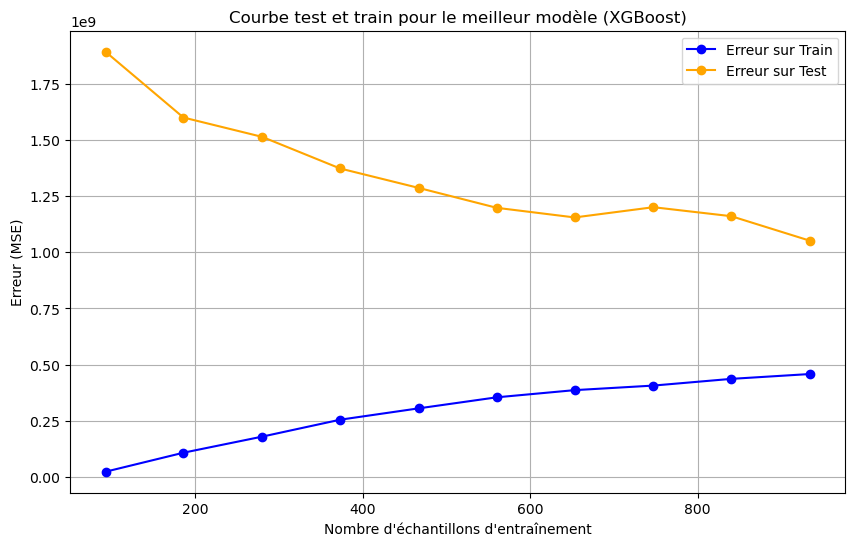

c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\I7 7eme\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

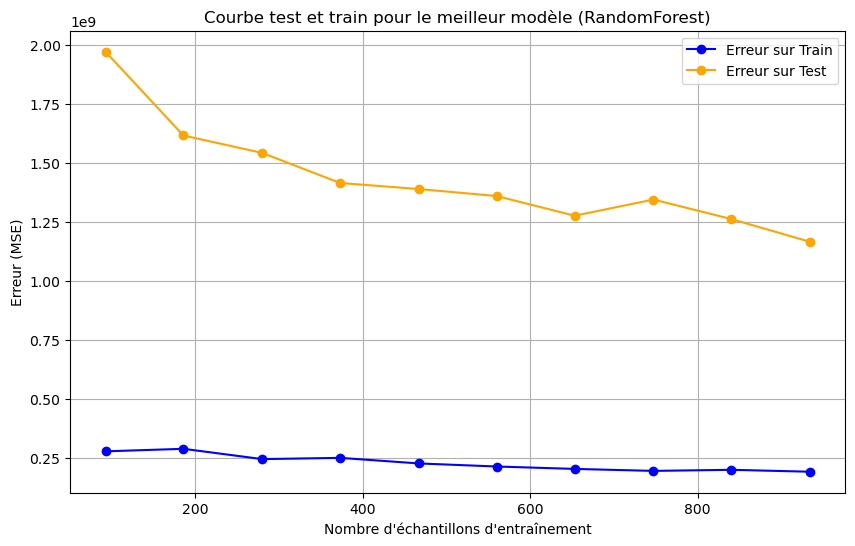

In [8]:

#Récupération des données de la variable cible sans log
y_train = y_train_s
y_test = y_test_s

# Tracer les courbes d'apprentissage pour le modèle sélectionné
def plot_learning_curves(model, X, y, scoring='neg_mean_squared_error',title="Courbe d'apprentissage Test et Train"):
    
    # Définir une validation croisée
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    # Calcul des courbes d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Moyenne des erreurs (on prend l'opposé car sklearn retourne des scores négatifs pour MSE)
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    # Tracer les courbes
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Erreur sur Train")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="Erreur sur Test")

    plt.title(title)
    plt.xlabel("Nombre d'échantillons d'entraînement")
    plt.ylabel("Erreur (MSE)")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Appliquer à votre modèle
plot_learning_curves(best_model_row["Best Model"], X_train, y_train, scoring='neg_mean_squared_error',title=f"Courbe test et train pour le meilleur modèle ({best_model_row['Model']})")
plot_learning_curves(best_model_row2["Best Model"], X_train, y_train, scoring='neg_mean_squared_error',title=f"Courbe test et train pour le meilleur modèle ({best_model_row2['Model']})")


#### Erreur d'entraînement :

La courbe bleue montre une augmentation progressive de l'erreur sur l'ensemble d'entraînement à mesure que le nombre d'échantillons d'entrainement. Cela est probablement dû à l'effet de régularisation ou à des ajustements pour éviter le surapprentissage (overfitting). Cela peut aussi refléter une réduction de la complexité du modèle (par exemple, en limitant le nombre d'itérations ou en augmentant la régularisation).

#### Erreur de test  :

La courbe orange montre une diminution de l'erreur sur l'ensemble de test, qui tend à se stabiliser. Cela indique que le modèle généralise mieux à mesure que l'entraînement progresse.
Analyse combinée :

La divergence entre les deux courbes est un indicateur de l'équilibre entre biais et variance. En effet, au début, l'erreur d'entraînement est faible et l'erreur de test est plus élevée, suggérant un surapprentissage (le modèle est trop ajusté aux données d'entraînement).A mesure que la taille de l'échantillon d'entrainement augmente, l'erreur d'entraînement augmente légèrement, et l'erreur de test diminue, ce qui indique que le modèle commence à généraliser de manière optimale.Les deux courbes tendent finalement à converger, ce qui est un signe positif que le modèle est bien équilibré entre biais et variance.

## Résultats finaux avec le meilleur modèle

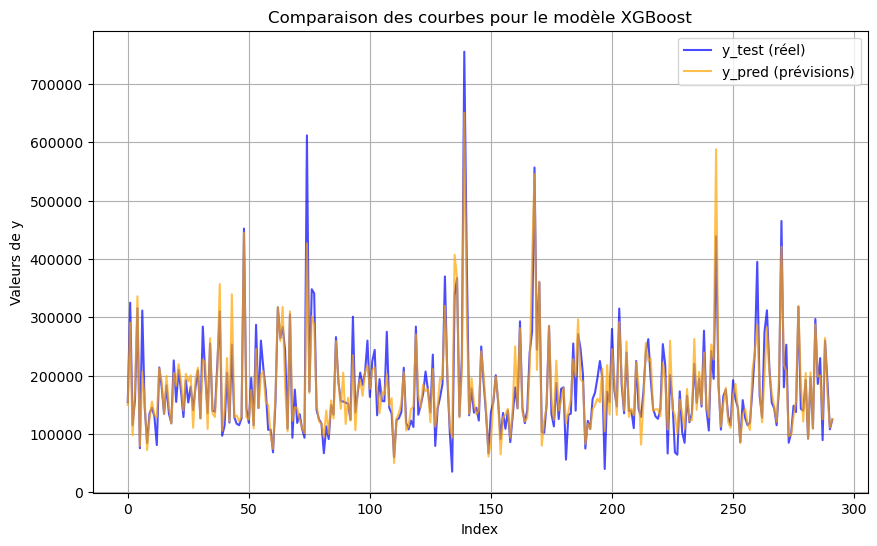

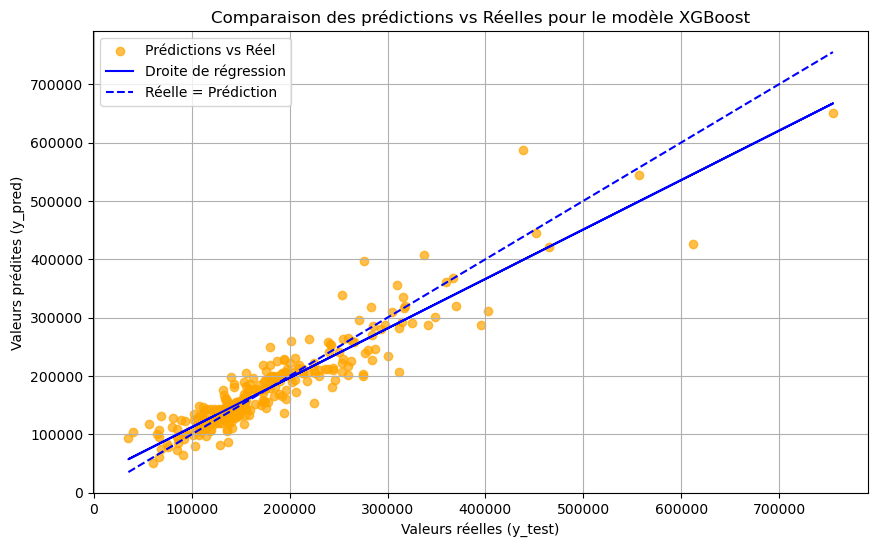


Le MSE final sur le jeu de test est : 1035333986.8813071


In [9]:


# Utilisation du meilleur modèle pour obtenir les coefficients et leur significativité
if best_model_row["Model"] == "LinearRegression()":
    best_model = LinearRegression()
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Calcul des coefficients et de leur significativité avec statsmodels
    X_train_sm = sm.add_constant(X_train)  # Ajout d'une constante pour le biais
    ols_model = sm.OLS(y_train, X_train_sm).fit()
    coefficients = pd.DataFrame({
        "Feature": ["Intercept"] + list(X_train.columns),
        "Coefficient": ols_model.params,
        "P-Value": ols_model.pvalues
    })
    # Affichage des coefficients et de leurs significativités
    print("\nCoefficients et significativités :")
    print(coefficients)


elif best_model_row["Model"] in ["ridge", "lasso", "elasticNet"]:
    best_model = best_model_row["Best Model"]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Extraction des coefficients
    coefficients = pd.DataFrame({
        "Feature": list(X_train.columns),
        "Coefficient": best_model.coef_
    })
    coefficients["P-Value"] = "N/A"  # Les modèles régularisés n'ont pas de significativité statistique
    # Affichage des coefficients et de leurs significativités
    print("\nCoefficients et significativités :")
    print(coefficients)


else:
    best_model = best_model_row["Best Model"]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Ces modèles (XGBoost, RandomForest et Adaboost) n'ont pas de coefficients interprétables
    coefficients = pd.DataFrame({
        "Feature": list(X_train.columns),
        "Coefficient": "N/A",
        "P-Value": "N/A"
    })


y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Création d'un graphique comparant y_test et y_pred
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="y_test (réel)", color="blue", alpha=0.7)
plt.plot(range(len(y_pred)), y_pred, label="y_pred (prévisions)", color="orange", alpha=0.7)
plt.title(f"Comparaison des courbes pour le modèle {best_model_row['Model']}")
plt.xlabel("Index")
plt.ylabel("Valeurs de y")
plt.legend()
plt.grid(True)
plt.show()


# Création d'un graphique comparant y_test et y_pred avec un scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot des valeurs réelles contre les prédictions
plt.scatter(y_test, y_pred, color='orange', alpha=0.7, label="Prédictions vs Réel")

# Droite de régression (calculée sur les prédictions vs réelles)
reg_model = LinearRegression()
reg_model.fit(y_test.values.reshape(-1, 1), y_pred)  # Ajustement de la droite de régression
y_pred_reg = reg_model.predict(y_test.values.reshape(-1, 1))  # Prédictions de la droite de régression

# Tracer la droite de régression
plt.plot(y_test, y_pred_reg, color='blue', linestyle='-', label="Droite de régression")

# Si y_test et y_pred sont des pandas Series, vous pouvez les convertir en numpy arrays
y_test = y_test.to_numpy()  # Convertir en numpy array


# Calculer les valeurs minimales et maximales
min_val = min(np.min(y_test), np.min(y_pred))
max_val = max(np.max(y_test), np.max(y_pred))

# Tracer la bissectrice (la ligne où y_test = y_pred)
plt.plot([min_val, max_val], [min_val, max_val], color="blue", linestyle="--", label="Réelle = Prédiction")




# Courbe idéale de comparaison parfaite
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Réelle = Prédiction")


plt.title(f"Comparaison des prédictions vs Réelles pour le modèle {best_model_row['Model']}")
plt.xlabel("Valeurs réelles (y_test)")
plt.ylabel("Valeurs prédites (y_pred)")
plt.legend()
plt.grid(True)
plt.show()

# Calcul des performances finales sur l'ensemble des données train
final_mse = mean_squared_error(y_test, y_pred)
print(f"\nLe MSE final sur le jeu de test est : {final_mse}")

Pour les prix plus bas (jusqu'à environ 350 000), le modèle semble assez précis car les points jaunes sont proches de la ligne idéale;
Pour les prix plus élevés (au-delà de 400 000), on observe une plus grande dispersion des points et une tendance à sous-estimer les valeurs;
Il y a une légère sous-estimation générale des prix très élevés, car la ligne de régression bleue est en dessous de la ligne pointillée idéale.
Ainsi, Performe bien pour les prix dans la gamme moyenne-basse, a plus de difficulté à prédire précisément les prix très élevés et a une ontre une tendance à sous-estimer légèrement les valeurs extrêmes.

## Sauvegarde du modèle 

In [10]:
import joblib

# Supposons que `best_model` est votre modèle entraîné
model_filename = "best_model.pkl"
joblib.dump(best_model, model_filename)

print(f"Modèle sauvegardé sous le nom : {model_filename}")


Modèle sauvegardé sous le nom : best_model.pkl
